In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
import seaborn as sns

# Load the Dataset
file_path = "preprocessed_data/La_Liga_outfield_processed.csv"  
df = pd.read_csv(file_path)

X = df.drop(columns=["Player", "player_market_value_euro"], errors="ignore")  
y = df["player_market_value_euro"]

print(X.columns.tolist())

['Per90_% of Aerials Won', 'Per90_% of Dribblers Tackled', 'Per90_Aerials Won', 'Per90_Assists', 'Per90_Ball Recoveries', 'Per90_Blocks', 'Per90_Carries into Final Third', 'Per90_Challenges Lost', 'Per90_Clearances', 'Per90_Crosses into Penalty Area', 'Per90_Dribblers Tackled', 'Per90_Errors', 'Per90_Fouls Committed', 'Per90_Fouls Drawn', 'Per90_GCA (Fouls Drawn)', 'Per90_GCA (Shot)', 'Per90_GCA (Take-On)', 'Per90_Goals + Assists', 'Per90_Goals/Shot', 'Per90_Goals/Shot on Target', 'Per90_Interceptions', 'Per90_Key Passes', 'Per90_Pass Completion % (Long)', 'Per90_Pass Completion % (Medium)', 'Per90_Passes Attempted (Short)', 'Per90_Passes Blocked', 'Per90_Passes Offside', 'Per90_Passes into Penalty Area', 'Per90_Progressive Carrying Distance', 'Per90_Red Cards', 'Per90_SCA (Defensive Action)', 'Per90_SCA (Fouls Drawn)', 'Per90_SCA (Shot)', 'Per90_Shots from Free Kicks', 'Per90_Successful Take-On %', 'Per90_Switches', 'Per90_Tackles', 'Per90_Tackles (Att 3rd)', 'Per90_Tackles (Def 3rd)'

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/var/folders/wr/76t2vdtd0dl7qb0sjrvmpfz40000gn/T/ipykernel_27005/3348367826.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cv_results = cv_results.groupby(['param_n_estimators', 'param_max_depth'], as_index=False).mean()


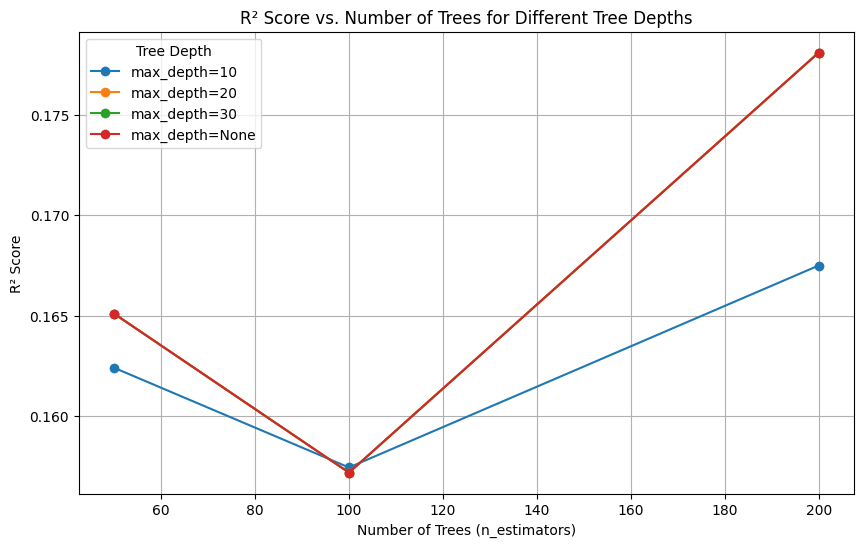


Best Hyperparameters Found:
max_depth: None
max_features: None
min_samples_leaf: 4
min_samples_split: 2
n_estimators: 200

📌 Mean Absolute Error (MAE): 0.83
📌 Mean Squared Error (MSE): 0.97
📌 R² Score: 0.23


In [2]:

# Split Data into Training and Testing Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a refined grid search space
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(
    rf_model, param_grid, 
    cv=5, scoring=['r2', 'neg_mean_absolute_error'], 
    refit='r2', n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

# Extract the best model
best_rf_model = grid_search.best_estimator_

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results['param_max_depth'] = cv_results['param_max_depth'].astype(str).replace("nan", "None")
cv_results = cv_results.drop_duplicates(subset=['param_n_estimators', 'param_max_depth'])
cv_results = cv_results.groupby(['param_n_estimators', 'param_max_depth'], as_index=False).mean()
cv_results['param_n_estimators'] = cv_results['param_n_estimators'].astype(int)

# Plot R² Score vs. Number of Trees (n_estimators)
plt.figure(figsize=(10, 6))

for depth in cv_results['param_max_depth'].unique():
    subset = cv_results[cv_results['param_max_depth'] == depth]
    plt.plot(subset['param_n_estimators'], subset['mean_test_r2'], marker='o', label=f"max_depth={depth}")

plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("R² Score")
plt.title("R² Score vs. Number of Trees for Different Tree Depths")
plt.legend(title="Tree Depth")
plt.grid(True)
plt.show()

print("\nBest Hyperparameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Show Grid Search Results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split',
                         'param_min_samples_leaf', 'param_max_features', 'mean_test_r2', 'mean_test_neg_mean_absolute_error']]

# Make Predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📌 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📌 Mean Squared Error (MSE): {mse:.2f}")
print(f"📌 R² Score: {r2:.2f}")

# # Perform Permutation Importance
# perm_importance = permutation_importance(best_rf_model, X_test, y_test, n_repeats=10, random_state=42)

# # Convert results to a DataFrame
# importance_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': perm_importance.importances_mean
# }).sort_values(by='Importance', ascending=False)

# # Plot Permutation Importance
# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
# plt.xlabel('Permutation Importance Score')
# plt.ylabel('Feature')
# plt.title('Permutation Feature Importance')
# plt.gca().invert_yaxis()  # Highest importance at the top
# plt.show()

# # Feature Importance Analysis from the Model
# feature_importance = best_rf_model.feature_importances_
# sorted_idx = np.argsort(feature_importance)[::-1]

# # Show Top 10 Features
# plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx[:10])), feature_importance[sorted_idx[:10]], align='center')
# plt.yticks(range(len(sorted_idx[:10])), [X.columns[i] for i in sorted_idx[:10]])
# plt.xlabel("Feature Importance")
# plt.title("Top 10 Most Important Features in Player Valuation")
# plt.gca().invert_yaxis()
# plt.show()

# # Show Bottom 10 Features
# plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx[-10:])), feature_importance[sorted_idx[-10:]], align='center')
# plt.yticks(range(len(sorted_idx[-10:])), [X.columns[i] for i in sorted_idx[-10:]])
# plt.xlabel("Feature Importance")
# plt.title("Top 10 Least Important Features in Player Valuation")
# plt.gca().invert_yaxis()
# plt.show()